# Machine-learning in Psi4
Here we will be discussing machine-learning techniques that can be applied to electronic structure problems. The following subjects will be covered:

 1. **Representing** a molecule
   1. Geometries and charges
   1. Coulomb matrices
 1. **Training** a machine-learning model for molecular energy
   1. Effects of training set
   1. Automatic training sets
 1. **Predicting** a potential energy surface
   1. Error metrics and extensions

## 0. Environment setup
We will be performing electronic structure calculations with the [Psi4](psicode.org) package and machine-learning with the [scikit-learn](scikit-learn.org) package. NumPy and Matplotlib will handle data manipulation and graphing.

In [1]:
import psi4
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

## 1. Representing a molecule
The machine-learning (ML) techniques we will be using attempt to find a model $f({\bf x})$ which can map a representation vector $\bf x$ onto some target value $y$:
$$f({\bf x}) = {\bf x}^T {\bf w},$$

$$y = f({\bf x}) + \epsilon$$
where $\epsilon$ is the **noise** or **error** of the model.

For our purposes, $\bf x$ is some vector **representation** of our molecule, and $y$ is some property we'd like to predict, such as the energy. We will start by calculating the energy of the water molecule across its symmetric O-H bond stretching mode.

In [2]:
# run across an H2O symmetric bond stretching surface
# 0.5 - 2.0 Angstroms, increments of 0.05, total of 32 geometries
# save geometry, nuclear charges (same across the surface...), and scf energy
psi4.set_options({
    'basis':'sto-3g'
})
geoms = []
qs = []
Es = []
rs = [i for i in np.arange(0.5,2.1,0.05)]
for i in rs:
    mol = psi4.geometry("""
    O
    H 1 """ + str(i) + """
    H 1 """ + str(i) + """ 2 104.5
    symmetry c1
    """)
    geoms.append(mol.geometry().to_array())
    qs.append(np.array([mol.fZ(i) for i in range(mol.natom())]))
    Es.append(psi4.energy('scf'))
    
# question for the student: does it matter whether the output geometry is in Angrstrom or Bohr?
## the output will be in Bohr, though we're using Angstrom as the input. Psi4 is just like that.
## that's okay, because it would just multiply our matrix by a scalar, which would
## multiply our dual-coefficients by that scalar. as long as we're consistent, it doesn't matter!

The change in the energy as the length of the O-H bonds change can be plotted as a slice of the potential energy surface.

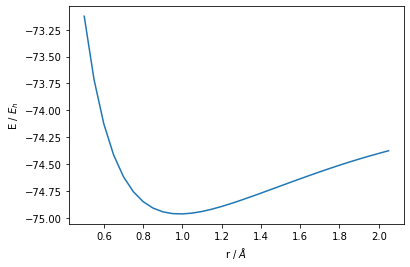

In [3]:
# plt the original surface
plt.plot(np.arange(0.5,2.1,0.05),list(Es))
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

At a glance, the energy seems to be a simple function of the bond length $r$. One could formulate this as a simple regression problem and solve for a function that maps $r$ into the energy $E$. However, if one wishes to use the resulting model for anything but the symmetric stretch, more information about the molecule would be necessary. We want to describe every bond.

To do this, we can encode the geometry of the molecule into a vector using each atom distance $r_{ij}$. To differentiate the O-H bond length from the H-H "bond", we will use the atomic charge $Z$ of each atom. The resulting matrix is called a **Coulomb matrix** $\bf C$, which takes the form:
$$
\begin{align}
C_{ij} = 
\begin{cases}
\frac{Z_iZ_j}{r_{ij}}&\text{for $i \neq j$}\\
0.5Z_i^{2.4}&\text{for $i=j$}\\
\end{cases}
\end{align}
$$

In [4]:
# build coulomb matrix according to https://singroup.github.io/dscribe/tutorials/coulomb_matrix.html
couls = []
for k in range(0,len(Es)): # loop over all geometries
    couls.append(np.zeros((len(qs[k]),len(qs[k])))) # n_atom x n_atom matrix
    for i in range(0,len(qs[k])): # n_atom rows
        for j in range(0,len(qs[k])): # n_atom columns
            if i == j:
                couls[k][i][j] = qs[k][i] ** 2.4 / 2.0 # diagonal
            else:
                couls[k][i][j] = qs[k][i] * qs[k][j] / np.linalg.norm(geoms[k][i] - geoms[k][j])

In [5]:
print(couls[0])

[[73.51669472  8.46683537  8.46683537]
 [ 8.46683537  0.5         0.66926039]
 [ 8.46683537  0.66926039  0.5       ]]


A. Can you tell which row and column correspond to which atoms? 
B. What would happen if you used different units for your bond distances?

**Answers:** 
A. Since $Z_H = 1$, then $0.5Z_h^{2.4} = 0.5$, putting hydrogen in the second and third row/column. The remainder must be oxygen.
B. Every off-diagonal element would be scaled by the inverse unit factor. 

## 2. Training a ML model for molecular energy
Now we may take our Coulomb matrix elements and use them as features for a ML model. We will flatten $\bf C$ into a 1D array, then find the optimum weights $w$ which map the features onto the correct energy.

If our feature vector $x$ is a vector containing all of the elements of $\bf C$, how many elements will there be in our weight vector $w$?

**Answer:** If $\bf C$ is an $n \times n$ matrix, where $n$ is the number of atoms, then both $x$ and $w$ will be vectors of length $n \times n$.

In [6]:
# set up a training set - 4 evenly-spaced points on the PES
training = [0,7,15,23] 
X = [couls[t].flatten() for t in training]
y = [Es[t] for t in training]
reg = LinearRegression().fit(X,y)

In [7]:
reg.score(X,y)

0.7399670553716275

In [8]:
# set up prediction (test) set - all points except training set
predict = [i for i in range(0,32)]
for t in sorted(training,reverse=True):
    del predict[t]
Xp = [couls[p].flatten() for p in predict]
yp = reg.predict(Xp)

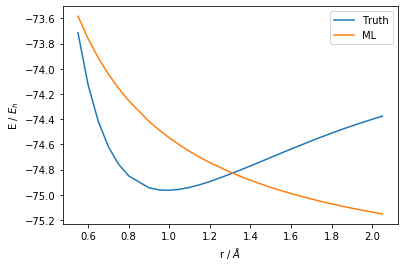

In [9]:
plt.plot(np.asarray(rs)[predict],[Es[p] for p in predict],label='Truth')
plt.plot(np.asarray(rs)[predict],yp,label='ML')
axes = plt.gca()
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

In [10]:
# train a KRR model w/ RBF kernel, wide grid search 3-fold CV w/ NMSE scoring
krr = KernelRidge(kernel='rbf')
parameters = {'alpha':np.logspace(-12,12,num=24),
              'gamma':np.logspace(-12,12,num=24)}
krr_regressor = GridSearchCV(krr,parameters,cv=3,scoring='neg_mean_squared_error')
# need to flatten each representation for skl
#krr_regressor.fit([couls[k].flatten() for k in np.arange(0.5,2.1,0.05)],list(Es.values()))
krr_regressor.fit(X,y)
yp = krr_regressor.predict(Xp)

/Users/mash/miniconda3/envs/p4dev/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


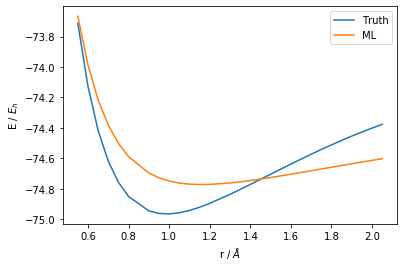

In [11]:
plt.plot(np.asarray(rs)[predict],[Es[p] for p in predict],label='Truth')
plt.plot(np.asarray(rs)[predict],yp,label='ML')
axes = plt.gca()
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

In [12]:
training = [0,3,7,11,15,19,23,27]
X = [couls[t].flatten() for t in training]
y = [Es[t] for t in training]

predict = [i for i in range(0,32)]
for t in sorted(training,reverse=True):
    del predict[t]
    
Xp = [couls[p].flatten() for p in predict]
yp = reg.predict(Xp)

In [13]:
krr = KernelRidge(kernel='rbf')
parameters = {'alpha':np.logspace(-12,12,num=24),
              'gamma':np.logspace(-12,12,num=24)}
krr_regressor = GridSearchCV(krr,parameters,cv=3,scoring='neg_mean_squared_error')
krr_regressor.fit(X,y)
yp = krr_regressor.predict(Xp)

/Users/mash/miniconda3/envs/p4dev/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


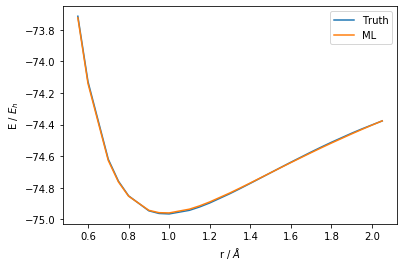

In [14]:
plt.plot(np.asarray(rs)[predict],[Es[p] for p in predict],label='Truth')
plt.plot(np.asarray(rs)[predict],yp,label='ML')
axes = plt.gca()
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

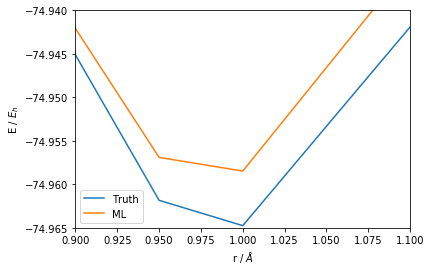

In [15]:
# error is in the mEh range for H2O- let's zoom in
plt.plot(np.asarray(rs)[predict],[Es[p] for p in predict],label='Truth')
plt.plot(np.asarray(rs)[predict],yp,label='ML')
axes = plt.gca()
axes.set_xlim([0.9,1.1])
axes.set_ylim([-74.965,-74.94])
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

In [16]:
# what about the assymetric stretching hypersurface?
psi4.set_options({
    'basis':'sto-3g'
})
geoms = []
qs = []
rs = [i for i in np.arange(0.5,2.1,0.1)]
Es = np.zeros((len(rs),len(rs)))
for i in range(0,len(rs)):
    for j in range(0,len(rs)):
        mol = psi4.geometry("""
        O
        H 1 """ + str(rs[i]) + """
        H 1 """ + str(rs[j]) + """ 2 104.5
        symmetry c1
        """)
        geoms.append(mol.geometry().to_array())
        qs.append(np.array([mol.fZ(i) for i in range(mol.natom())]))
        Es[i][j] = psi4.energy('scf')

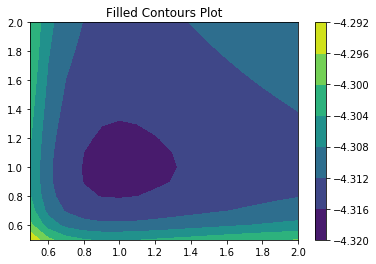

In [17]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(rs, rs, -1*np.log(-1*np.asarray(Es)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
#ax.set_ylabel('y (cm)')
plt.show()

In [18]:
couls = []
for k in range(0,len(geoms)): # loop over all geometries
    couls.append(np.zeros((len(qs[k]),len(qs[k])))) # n_atom x n_atom matrix
    for i in range(0,len(qs[k])): # n_atom rows
        for j in range(0,len(qs[k])): # n_atom columns
            if i == j:
                couls[k][i][j] = qs[k][i] ** 2.4 / 2.0 # diagonal
            else:
                couls[k][i][j] = qs[k][i] * qs[k][j] / np.linalg.norm(geoms[k][i] - geoms[k][j])

In [19]:
trainers = np.random.randint(0,len(rs)**2,20)
X = [couls[t].flatten() for t in trainers]
y = [Es.flatten()[t] for t in trainers]

krr = KernelRidge(kernel='rbf')
parameters = {'alpha':np.logspace(-12,12,num=24),
              'gamma':np.logspace(-12,12,num=24)}
krr_regressor = GridSearchCV(krr,parameters,cv=3,scoring='neg_mean_squared_error')
krr_regressor.fit(X,y)

pred = krr_regressor.predict([couls[p].flatten() for p in range(0,len(couls))])
pred = np.reshape(pred,(len(rs),len(rs)))

/Users/mash/miniconda3/envs/p4dev/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


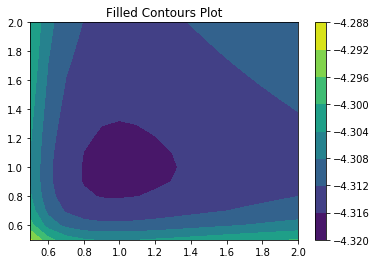

In [20]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(rs, rs, -1*np.log(-1*np.asarray(pred)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
#ax.set_ylabel('y (cm)')
plt.show()

In [21]:
print("Mean prediction error across the surface: {}".format(np.mean(pred - Es)))

Mean prediction error across the surface: 0.00151061633606131
